In [6]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import pandas as pd
from fastbook import *
from fastai.tabular.all import *
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error
from dtreeviz.trees import *
import sklearn

def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

traindf = pd.read_csv('C:/Users/jsult/Desktop/spacetitanic3/train.csv',low_memory=False)
testdf = pd.read_csv('C:/Users/jsult/Desktop/spacetitanic3/test.csv',low_memory= False)
traindf['train'] = True
testdf['train'] = False
togeth = pd.concat([traindf,testdf])



after the not guessy imputations drop rows with too many missing values

In [7]:
essentialcolumns = list(traindf.columns)
togeth[essentialcolumns].isna().sum(axis = 1).value_counts()

0    6606
1    5148
2    1082
3     130
4       4
Name: count, dtype: int64

if droptestnas

In [8]:
nas = list(testdf.isna().sum(axis = 1))
indexes = list(testdf.index)
keepinds = []
dropinds = []
for i in range(len(indexes)):
    if nas[i] == 0:
        keepinds.append(i)
    else:
        dropinds.append(i)
droptest = testdf.loc[dropinds].copy()
testdf = testdf.loc[keepinds].copy()

if split cryosleep

In [9]:
cryotrain = traindf[traindf.CryoSleep == True].copy()
cryotest = testdf[testdf.CryoSleep == True].copy()

Impute cabins, split group number, split names, split cabins

In [10]:
def split_group_number(df):
    df['Group'] = df['PassengerId'].apply(lambda x: x.split("_")[0] if pd.notna(x) else pd.NA)
    df.Group = df.Group.astype('float')
    df['GroupNumber'] = df['PassengerId'].apply(lambda x: x.split("_")[1] if pd.notna(x) else pd.NA)
    df.GroupNumber = df.GroupNumber.astype('float')
    return df

def split_names(df):
    # Create new columns for first name and last name
    df['FirstName'] = df['Name'].apply(lambda x: x.split()[0] if pd.notna(x) else pd.NA)
    df['LastName'] = df['Name'].apply(lambda x: x.split()[1] if pd.notna(x) else pd.NA)
    return df

def sort_df_group(df):
    df = df.sort_values(by = ['Group','GroupNumber'])
    df.reset_index(inplace = True)
    df.drop(columns = 'index',inplace = True)
    return df

def initial_splits(df):
    df = split_group_number(df)
    df = split_names(df)
    df = sort_df_group(df)
    return df


In [11]:
togeth = initial_splits(togeth)

In [20]:
with open('C:/Users/jsult/Desktop/spacetitanic3/FINAL transferred/idtocabin2.pkl', 'rb') as fp:
    idtocabin = pickle.load(fp)

def cabinimpute(df):
    for i,row in df.iterrows():
        
        if pd.isna(row.Cabin):
            if row.PassengerId in idtocabin:
                df.at[i,'Cabin'] = idtocabin[row.PassengerId]
    return togeth
def split_cabin(df):
    df['CabinDeck'] = df['Cabin'].apply(lambda x: x.split("/" )[0] if pd.notna(x) else pd.NA)
    custom_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']
    df['CabinDeck'] = pd.Categorical(df['CabinDeck'], categories=custom_order, ordered=True)
    df['CabinSide'] = df['Cabin'].apply(lambda x: x.split("/")[2] if pd.notna(x) else pd.NA)
    df['CabinNum'] = df['Cabin'].apply(lambda x: int(x.split("/")[1]) if pd.notna(x) else pd.NA)
    return df

def imp_cabin_pre_splits(df):
    df = cabinimpute(df)
    df = split_cabin(df)
    return df





In [21]:
togeth = imp_cabin_pre_splits(togeth)


In [22]:
togeth.isna().sum()

PassengerId        0
HomePlanet        13
CryoSleep        136
Cabin             52
Destination      274
Age              270
VIP              296
RoomService      162
FoodCourt        171
ShoppingMall     163
Spa              166
VRDeck           150
Name             294
Transported     4277
train              0
Group              0
GroupNumber        0
FirstName        294
LastName         294
CabinDeck         52
CabinSide         52
CabinNum          52
dtype: int64

## Impute certainties

Cabinside

In [23]:
def fill_cabin_side_by_group(df):
    for index, row in df.iterrows():
        if pd.isna(row['CabinSide']):
            matching_rows = togeth[togeth['Group'] == row['Group']]
            non_nan_deck = matching_rows.dropna(subset=['CabinSide'])
            if not non_nan_deck.empty:
                side_to_fill = non_nan_deck['CabinSide'].values[0]
                df.at[index, 'CabinSide'] = side_to_fill
    return df

In [24]:
togeth = fill_cabin_side_by_group(togeth)

Spending

In [25]:
cryodict = {'RoomService':0,'FoodCourt' : 0, 'ShoppingMall' : 0, 'Spa' : 0, 'VRDeck' : 0}
def fillspending0(df):
    df.loc[df.CryoSleep == True, list(cryodict.keys())] = df.loc[df.CryoSleep == True, list(cryodict.keys())].fillna(value=cryodict)
    return df

spending = ['RoomService','FoodCourt','ShoppingMall','Spa', 'VRDeck']
def spending_under_13(df):
    df.loc[df.Age < 13, spending] = df.loc[df.Age < 13, spending].fillna(0)
    return df
def spending_impute(df):
    df = fillspending0(df)
    df = spending_under_13(df)
    return df


In [26]:
togeth = spending_impute(togeth)

CryoSleep

In [27]:
def not_cryosleep_if_spending(df):
    for index, row in df[df['CryoSleep'].isna()].iterrows():
        if (row[spending] > 0).any():
            df.at[index, 'CryoSleep'] = False
    return df


In [28]:
togeth = not_cryosleep_if_spending(togeth)

HomePlanet

In [29]:
def fill_home_planet_by_last_name(df):
    for index, row in df.iterrows():
        if pd.isna(row['HomePlanet']):
            matching_rows = df[df['LastName'] == row['LastName']]
            non_nan_planet = matching_rows.dropna(subset=['HomePlanet'])
            if not non_nan_planet.empty:
                planet_to_fill = non_nan_planet['HomePlanet'].values[0]
                df.at[index, 'HomePlanet'] = planet_to_fill
    return df

def fill_home_planet_by_group(df):
    for index, row in df.iterrows():
        if pd.isna(row['HomePlanet']):
            matching_rows = df[df['Group'] == row['Group']]
            non_nan_planet = matching_rows.dropna(subset=['HomePlanet'])
            if not non_nan_planet.empty:
                planet_to_fill = non_nan_planet['HomePlanet'].values[0]
                df.at[index, 'HomePlanet'] = planet_to_fill
    return df

def home_planet_from_cabindeck_abc(df):
    df.loc[df['CabinDeck'].isin(['A', 'B', 'C']), 'HomePlanet'] = df.loc[df['CabinDeck'].isin(['A', 'B', 'C']), 'HomePlanet'].fillna('Europa')
    return df

def home_planet_from_cabindeck_g(df):
    df.loc[df['CabinDeck']== 'G', 'HomePlanet'] = df.loc[df['CabinDeck'] == 'G', 'HomePlanet'].fillna('Earth')
    return df

def homeplanet_impute(df):
    df = fill_home_planet_by_group(df)
    df = fill_home_planet_by_last_name(df)
    df = home_planet_from_cabindeck_abc(df)
    df = home_planet_from_cabindeck_g(df)
    return df


In [30]:
togeth = homeplanet_impute(togeth)

VIP

In [31]:
def not_vip_earth(df):
    df.loc[df.HomePlanet == 'Earth','VIP'] = df.loc[df.HomePlanet == 'Earth','VIP'].fillna(False)
    return df
def not_vip_underage(df):
    df.loc[df.Age < 18,'VIP'] = df.loc[df.Age < 18, 'VIP'].fillna(False)
    return df
def not_vip_mars_cryo(df):
    df.loc[(df.HomePlanet == 'Mars') & (df.CryoSleep == True),'VIP'] = df.loc[(df.HomePlanet == 'Mars') & (df.CryoSleep == True),'VIP'].fillna(False)
    return df
def not_vip_g(df):
    df.loc[df.CabinDeck == 'G','VIP'] = df.loc[df.CabinDeck == 'G','VIP'].fillna(False)
    return df
def vip_impute(df):
    df = not_vip_underage(df)
    df = not_vip_earth(df)
    df = not_vip_mars_cryo(df)
    df = not_vip_g(df)
    return df


In [32]:
togeth = vip_impute(togeth)

## Feature Engineering

spending

In [33]:
def total_ammenities(df):
    df['TotalAmmenities'] = df[['Spa','VRDeck','FoodCourt','ShoppingMall']].sum(axis = 1)
    return df


def total_cabin_ammenities(df):
    def total_cabin_ammenities_apply(row):
        if pd.isna(row.Cabin):
            return pd.NA
        samecabin = df[df.Cabin == row.Cabin]
        return np.sum(samecabin.TotalAmmenities)
    df['TotalCabinAmmenities'] = df.apply(total_cabin_ammenities_apply, axis = 1)
    return df

spends = ['Spa','FoodCourt','VRDeck','ShoppingMall','RoomService']

def total_spending(df):
    def total_spending_apply(row):
        if pd.isna(row.RoomService):
            return pd.NA
        else:
            totalspending = 0
            for item in spends:
                if not pd.isna(row[item]):
                    totalspending += row[item]
            return totalspending
    df['TotalSpending'] = df.apply(total_spending_apply, axis = 1)
    return df

def total_cabin_spending(df):
    def total_cabin_spending_apply(row):
        if pd.isna(row.Cabin):
            return pd.NA
        samecabin = df[df.Cabin == row.Cabin]
        return np.sum(samecabin.TotalSpending)
    df['TotalCabinSpending'] = df.apply(total_cabin_spending_apply, axis = 1)
    return df

def total_cabin_room_service(df):
    def total_cabin_room_service_apply(row):
        if pd.isna(row.Cabin):
            return pd.NA
        samecabin = df[df.Cabin == row.Cabin]
        return np.sum(samecabin.RoomService)
    df['TotalCabinRoomService'] = df.apply(total_cabin_room_service_apply, axis = 1)
    return df

def calculate_family_spending(df):
    # Define the columns related to spending
    spending_columns = ['VRDeck', 'Spa', 'RoomService', 'FoodCourt', 'ShoppingMall']

    # Group the DataFrame by last name and group, and calculate the total spending for each family
    family_spending = df.groupby(['LastName', 'Group'])[spending_columns].transform('sum')

    # Rename the family spending columns to distinguish them from the original columns
    family_spending.columns = [col + '_Family' for col in spending_columns]

    # Add the total family spending and total family amenities columns to the DataFrame
    df = pd.concat([df, family_spending], axis=1)

    famamenities = ['VRDeck_Family', 'Spa_Family', 'FoodCourt_Family', 'ShoppingMall_Family']
    famspending = ['VRDeck_Family', 'Spa_Family', 'RoomService_Family', 'FoodCourt_Family', 'ShoppingMall_Family']
    df['TotalFamilyAmmenities'] = df[famamenities].sum(axis=1)
    df['TotalFamilySpending'] = df[famspending].sum(axis=1)

    return df

def spendingFE(df):
    df = total_ammenities(df)
    df = total_cabin_ammenities(df)
    df = total_spending(df)
    df = total_cabin_spending(df)
    df = total_cabin_room_service(df)
    df = calculate_family_spending(df)
    return df

In [34]:
togeth = spendingFE(togeth)

GroupSize,CabinSize,Family Size, Solo Cabin

In [ ]:
def group_size(df):
    def group_size_apply(row):
        group = df[df.Group == row.Group]
        return len(group)
    df['GroupSize'] = df.apply(group_size_apply, axis = 1)
    return df

def family_size(df):
    df['FamilySize'] = df.apply(lambda row: pd.NA if pd.isna(row['LastName']) else df[(df['LastName'] == row['LastName']) & (df['Group'] == row['Group'])].shape[0], axis=1)
    return df

def cabin_size(df):
    def cabin_size_apply(row):
        if pd.isna(row.Cabin):
            if row.GroupSize == 1:
                return 1
            else:
                return pd.NA
        else:
            samecabin = df[df.Cabin == row.Cabin]
            return len(samecabin)
    df['CabinSize'] = df.apply(cabin_size_apply, axis = 1)
    return df

def solo_cabin(df):
    def solo_cabin_apply(row):
        if pd.isna(row.Cabin):
            if row.GroupSize == 1:
                return True
            else:
                return pd.NA
        size = len(df[df.Cabin == row.Cabin])
        return size == 1
    df['SoloCabin'] = df.apply(solo_cabin_apply, axis = 1)
    return df

def sizeFE(df):
    df = group_size(df)
    df = family_size(df)
    df = cabin_size(df)
    df = solo_cabin(df)
    return df


In [ ]:
togeth = sizeFE(togeth)

Age

In [ ]:
def under_13(df):
    df['Under13'] = df['Age'].apply(lambda x: True if x < 13 else False if x >= 13 else pd.NA)
    return df

def under_18(df):
    df['Under18'] = df['Age'].apply(lambda x: True if x < 18 else False if x >= 18 else pd.NA)
    return df

def under_19(df):
    df['Under19'] = df['Age'].apply(lambda x: True if x < 19 else False if x >= 19 else pd.NA)
    return df

def ageFE(df):
    df = under_13(df)
    df = under_18(df)
    df = under_19(df)
    return df

In [ ]:
togeth['Agebin'] = pd.qcut(togeth['Age'], 4)
togeth = ageFE(togeth)

# Additional Imputes Certainty

In [ ]:
def not_under_18_if_vip(df):
    df['Under18'] = df.apply(lambda row: False if pd.isna(row['Age']) and row['VIP'] == True else row['Under18'], axis=1)
    return df

def not_under_13_if_spending(df):
    for index, row in df[df['Under13'].isna()].iterrows():
        if (row[spending] > 0).any():
            df.at[index, 'Under13'] = False
    return df

def age_impute(df):
    df = not_under_13_if_spending(df)
    df = not_under_18_if_vip(df)
    return df
# Call the function to update the DataFrame


def additionalimputes(df):
    df = age_impute(df)
    return df

In [ ]:
togeth = additionalimputes(togeth)

# Drop train data missing too many essential columns

## Next


In [ ]:
columnscount = list(togeth.columns)
columnscount.remove('Transported')
columnscount.remove('Name')
columnscount.remove('FirstName')
columnscount.remove('LastName')
columnscount.remove('train')
columnscount.remove('Group')
columnscount.remove('GroupNumber')
columnscount.remove('PassengerId')



In [ ]:
togeth[columnscount].isna().sum().sum()

4863

In [ ]:
len(togeth[togeth.train==True])

8693

In [ ]:
len(togeth[togeth.train==True].dropna())

7476

In [ ]:
len(togeth[togeth.train == False])

4277

In [ ]:
len(togeth[togeth.drop(columns = 'Transported').train==False].drop(columns = 'Transported').dropna())

3662

In [ ]:
traindf.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'train'],
      dtype='object')

In [ ]:
togeth[togeth.CryoSleep.isna()]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,train,Group,GroupNumber,FirstName,LastName,CabinDeck,CabinSide,CabinNum,TotalAmmenities,TotalCabinAmmenities,TotalSpending,TotalCabinSpending,TotalCabinRoomService,VRDeck_Family,Spa_Family,RoomService_Family,FoodCourt_Family,ShoppingMall_Family,TotalFamilyAmmenities,TotalFamilySpending,GroupSize,FamilySize,CabinSize,SoloCabin,Agebin,Under13,Under18,Under19
134,0099_02,Earth,NaN,G/12/P,TRAPPIST-1e,2.0,False,0.0,0.0,0.0,0.0,0.0,Thewis Connelson,True,True,99.0,2.0,Thewis,Connelson,G,P,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1,1,True,"(-0.001, 19.0]",True,True,True
158,0115_01,Mars,NaN,F/24/P,TRAPPIST-1e,26.0,False,0.0,0.0,0.0,0.0,NaN,Rohs Pead,True,True,115.0,1.0,Rohs,Pead,F,P,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,True,"(19.0, 27.0]",False,False,False
208,0156_01,Mars,NaN,F/34/P,TRAPPIST-1e,NaN,False,0.0,0.0,0.0,0.0,0.0,Tures Upead,NaN,False,156.0,1.0,Tures,Upead,F,P,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,True,NaN,<NA>,<NA>,<NA>
232,0175_02,Earth,NaN,G/25/P,55 Cancri e,8.0,False,0.0,0.0,0.0,0.0,0.0,Elody Benney,NaN,False,175.0,2.0,Elody,Benney,G,P,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,5,5,False,"(-0.001, 19.0]",True,True,True
266,0198_01,Earth,NaN,G/30/P,PSO J318.5-22,52.0,False,0.0,0.0,0.0,0.0,0.0,Jeroy Cookson,True,True,198.0,1.0,Jeroy,Cookson,G,P,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,True,"(38.0, 79.0]",False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12846,9193_01,Earth,NaN,G/1483/S,PSO J318.5-22,35.0,False,0.0,0.0,0.0,0.0,0.0,Camily Howence,False,True,9193.0,1.0,Camily,Howence,G,S,1483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,True,"(27.0, 38.0]",False,False,False
12854,9197_01,Europa,NaN,C/308/P,55 Cancri e,44.0,False,0.0,0.0,0.0,0.0,0.0,Bellus Platch,True,True,9197.0,1.0,Bellus,Platch,C,P,308,0.0,24551.0,0.0,26120.0,1569.0,8091.0,3854.0,1569.0,12598.0,8.0,24551.0,26120.0,4,4,4,False,"(38.0, 79.0]",False,False,False
12870,9206_03,Europa,NaN,B/352/S,55 Cancri e,32.0,False,0.0,0.0,0.0,0.0,0.0,Enifik Pokebox,NaN,False,9206.0,3.0,Enifik,Pokebox,B,S,352,0.0,10027.0,0.0,10027.0,0.0,3114.0,231.0,0.0,6677.0,5.0,10027.0,10027.0,3,3,3,False,"(27.0, 38.0]",False,False,False
12901,9227_05,Earth,NaN,G/1498/P,TRAPPIST-1e,8.0,False,0.0,0.0,0.0,0.0,0.0,Hard Hinglendez,False,True,9227.0,5.0,Hard,Hinglendez,G,P,1498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,5,5,False,"(-0.001, 19.0]",True,True,True


In [ ]:
togeth[columnscount].isna().sum()

HomePlanet                 6
CryoSleep                 88
Cabin                     52
Destination               48
Age                      270
VIP                      104
RoomService              162
FoodCourt                171
ShoppingMall             163
Spa                      166
VRDeck                   150
CabinDeck                 52
CabinSide                 22
CabinNum                  52
TotalAmmenities            0
TotalCabinAmmenities      52
TotalSpending            162
TotalCabinSpending        52
TotalCabinRoomService     52
VRDeck_Family            294
Spa_Family               294
RoomService_Family       294
FoodCourt_Family         294
ShoppingMall_Family      294
TotalFamilyAmmenities      0
TotalFamilySpending        0
GroupSize                  0
FamilySize               294
CabinSize                 30
SoloCabin                 30
Agebin                   270
Under13                  129
Under18                  268
Under19                  270
dtype: int64

## Really Guessing Imputes

## FillerFunction

In [ ]:
def fillerfunc(df,conds,target):
    for i,row in df[df[target].isna()].iterrows():
        go = True
        for nas in conds:
            if pd.isna(row[nas]):
                go = False
        if go:
            first = conds[0]
            a = (df[first] == row[first])
            for item in conds[1:]:
                a = a & (df[item] == row[item])
            valcounts = df[a][target].value_counts()
            if len(valcounts) == 0:
                continue
            if valcounts[0] > 25 and len(valcounts) == 1:
                df.loc[df.PassengerId == row.PassengerId,target] = df.loc[df.PassengerId == row.PassengerId,target].fillna(valcounts.index[0])
            elif valcounts[0] > 25 and len(valcounts) > 1 and valcounts[0] / valcounts[1] > 1.5:
                df.loc[df.PassengerId == row.PassengerId,target] = df.loc[df.PassengerId == row.PassengerId,target].fillna(valcounts.index[0])
            else:
                print("help")
                print("i",i)
                print("row",row)
                print("valcounts",valcounts.index[0])
    return df



homeplanet  - should be based on total spending and cabindeck

In [ ]:
def fillerfunc_homeplanet(df):
    return fillerfunc(df,['Destination','CabinDeck','Agebin'],'HomePlanet')

togeth = fillerfunc_homeplanet(togeth)

help
i 870
row PassengerId                      0616_01
HomePlanet                           NaN
CryoSleep                          False
Cabin                             E/40/S
Destination                  TRAPPIST-1e
Age                                 31.0
VIP                                False
RoomService                          0.0
FoodCourt                          428.0
ShoppingMall                         NaN
Spa                               1154.0
VRDeck                            1025.0
Name                     Arkaban Spriney
Transported                          NaN
train                              False
Group                              616.0
GroupNumber                          1.0
FirstName                        Arkaban
LastName                         Spriney
CabinDeck                              E
CabinSide                              S
CabinNum                              40
TotalAmmenities                   2607.0
TotalCabinAmmenities              2607.0
T

Destination

In [ ]:
def fillerfunc_destination(df):
    return fillerfunc(df,['CabinDeck','HomePlanet','Agebin'],'Destination')
togeth = fillerfunc_destination(togeth)

help
i 707
row PassengerId                       0504_03
HomePlanet                         Europa
CryoSleep                            True
Cabin                              B/19/S
Destination                           NaN
Age                                  24.0
VIP                                 False
RoomService                           0.0
FoodCourt                             0.0
ShoppingMall                          0.0
Spa                                   0.0
VRDeck                                0.0
Name                     Sterops Unpasine
Transported                          True
train                                True
Group                               504.0
GroupNumber                           3.0
FirstName                         Sterops
LastName                         Unpasine
CabinDeck                               B
CabinSide                               S
CabinNum                               19
TotalAmmenities                       0.0
TotalCabinAmmenitie

Cryosleep

if earth and E or F then not cryosleep!! or mars and d
if earth and g and trappist then cryosleep

In [ ]:
def fillerfunc_cryosleep(df):
    return fillerfunc(df,['HomePlanet','CabinDeck','VIP','Destination','Agebin'],'CryoSleep')
togeth = fillerfunc_cryosleep(togeth)

help
i 134
row PassengerId                       0099_02
HomePlanet                          Earth
CryoSleep                             NaN
Cabin                              G/12/P
Destination                   TRAPPIST-1e
Age                                   2.0
VIP                                 False
RoomService                           0.0
FoodCourt                             0.0
ShoppingMall                          0.0
Spa                                   0.0
VRDeck                                0.0
Name                     Thewis Connelson
Transported                          True
train                                True
Group                                99.0
GroupNumber                           2.0
FirstName                          Thewis
LastName                        Connelson
CabinDeck                               G
CabinSide                               P
CabinNum                               12
TotalAmmenities                       0.0
TotalCabinAmmenitie

## keep for checking cabins

In [ ]:
print(togeth[togeth.Cabin == 'G/2/S'])
for cab in togeth.Cabin.unique():
    group = togeth[togeth.Cabin == cab]
    if len(group.Group.unique()) > 1:
        print(cab)


   PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
15     0012_01      Earth     False  G/2/S  TRAPPIST-1e  31.0  False   

    RoomService  FoodCourt  ShoppingMall  Spa  VRDeck           Name  \
15         32.0        0.0         876.0  0.0     0.0  Justie Pooles   

   Transported  train  Group  GroupNumber FirstName LastName CabinDeck  \
15       False   True   12.0          1.0    Justie   Pooles         G   

   CabinSide CabinNum  TotalAmmenities TotalCabinAmmenities TotalSpending  \
15         S        2            876.0                876.0         908.0   

   TotalCabinSpending TotalCabinRoomService  VRDeck_Family  Spa_Family  \
15              908.0                  32.0            0.0         0.0   

    RoomService_Family  FoodCourt_Family  ShoppingMall_Family  \
15                32.0               0.0                876.0   

    TotalFamilyAmmenities  TotalFamilySpending  GroupSize FamilySize  \
15                  876.0                908.0        

In [ ]:
train = togeth[togeth.train == True].copy()
test = togeth[togeth.train == False].copy()

In [ ]:
train.drop(columns = 'train',inplace = True)
test.drop(columns = 'train',inplace = True)
test.drop(columns = 'Transported',inplace = True)


In [ ]:

nas = list(test.isna().sum(axis = 1))
indexes = list(test.index)
keepinds = []
dropinds = []
for i in range(len(list(test.index))):
    if test.isna().sum(axis = 1)[test.index[i]] > 0:
        dropinds.append(test.index[i])
    else:
        keepinds.append(test.index[i])
droptest = test.loc[dropinds].copy()
test = test.loc[keepinds].copy()

In [ ]:
train1 = train.copy()
train1.dropna(inplace = True)
test1 = test.copy()


In [ ]:
columns_to_convert = ['TotalCabinAmmenities', 'TotalSpending', 'TotalCabinRoomService', 'TotalFamilyAmmenities', 'TotalFamilySpending',
                      'TotalCabinSpending','CabinNum','CabinSize','FamilySize']

# Convert each column in the list to float
for column in columns_to_convert:
    if column in list(train1.columns):
        train1[column] = train1[column].astype('float')
        test1[column] = test1[column].astype('float')

In [ ]:
cat

['HomePlanet',
 'CryoSleep',
 'Destination',
 'VIP',
 'CabinDeck',
 'CabinSide',
 'SoloCabin',
 'Agebin',
 'Under13',
 'Under18']

In [ ]:
for item in ['Name','FirstName','LastName','GroupNumber','Under18','PassengerId','Cabin']:
    train1 = train1.drop(columns = item)

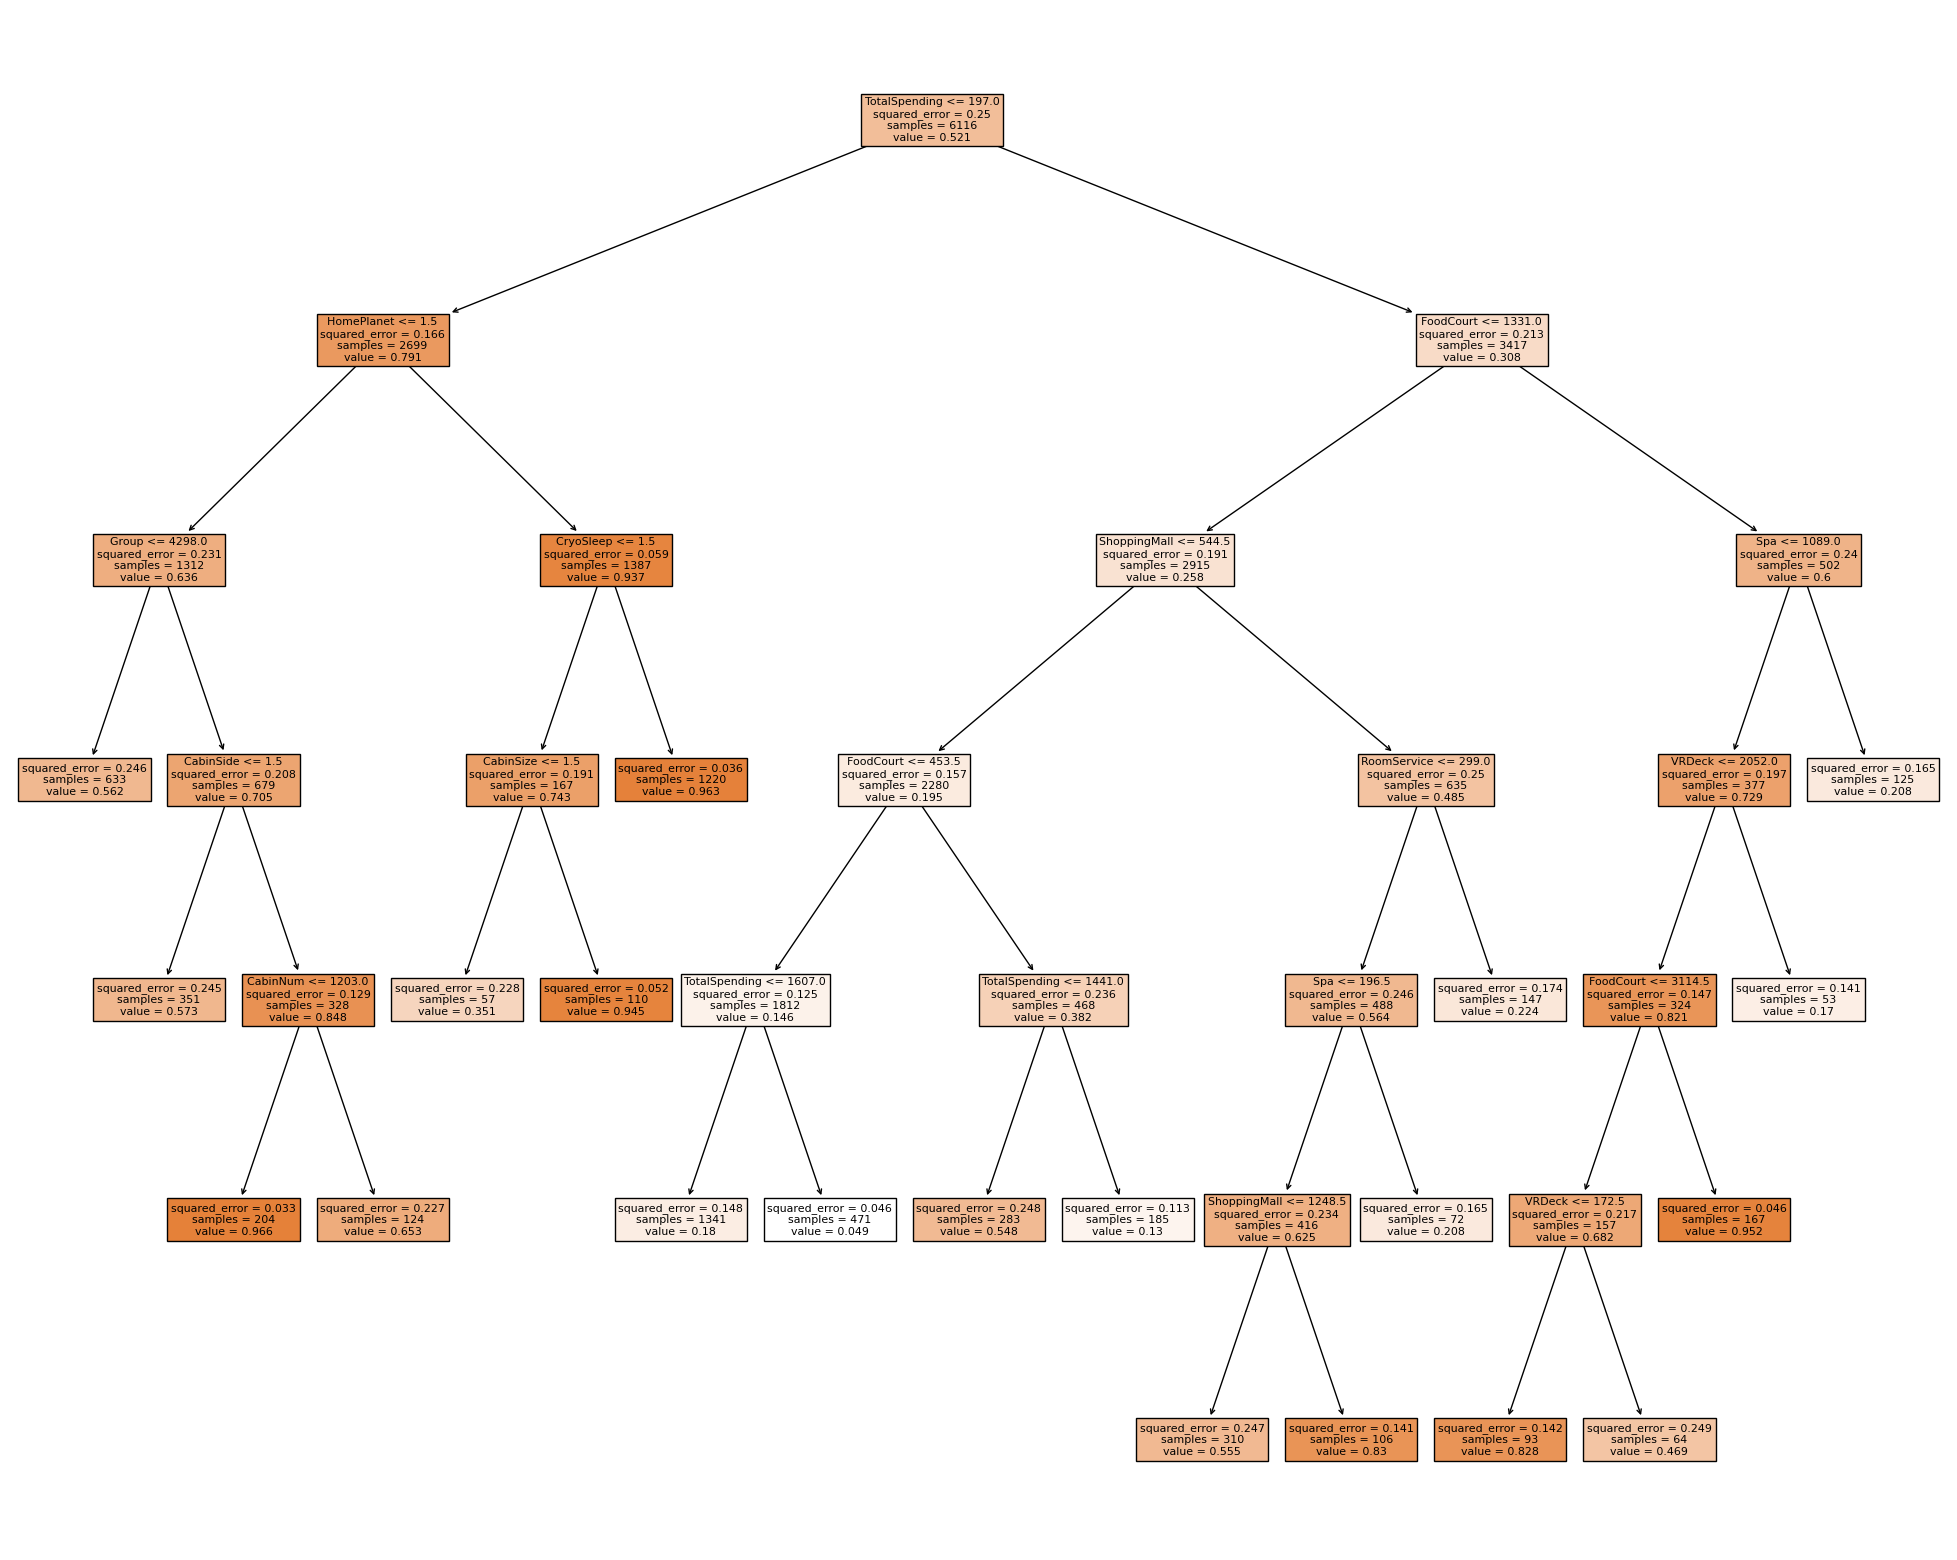

In [ ]:
splits = RandomSplitter(seed = 1)(range_of(train1))
dep_var = 'Transported'
procs = [Categorify,FillMissing]
cont,cat = cont_cat_split(train1, 1, dep_var=dep_var)
to = TabularPandas(train1, procs, cat, cont, y_names=dep_var,splits = splits)

xs,y = to.train.xs,to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

m = DecisionTreeRegressor(max_leaf_nodes=20)
m.fit(xs, y)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(m,
                   feature_names= xs.columns,
                   class_names = True,
                   filled=True)

In [ ]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = rf_feat_importance(m, xs)
print(fi[:30])

                     cols       imp
20          TotalSpending  0.551676
12              FoodCourt  0.112288
0              HomePlanet  0.088953
13           ShoppingMall  0.070083
14                    Spa  0.052995
15                 VRDeck  0.035455
32              CabinSize  0.019442
11            RoomService  0.019020
5               CabinSide  0.018770
17               CabinNum  0.011029
1               CryoSleep  0.010471
16                  Group  0.009819
22  TotalCabinRoomService  0.000000
31             FamilySize  0.000000
30              GroupSize  0.000000
29    TotalFamilySpending  0.000000
28  TotalFamilyAmmenities  0.000000
27    ShoppingMall_Family  0.000000
26       FoodCourt_Family  0.000000
25     RoomService_Family  0.000000
24             Spa_Family  0.000000
23          VRDeck_Family  0.000000
7                  Agebin  0.000000
21     TotalCabinSpending  0.000000
8                 Under13  0.000000
19   TotalCabinAmmenities  0.000000
18        TotalAmmenities  0

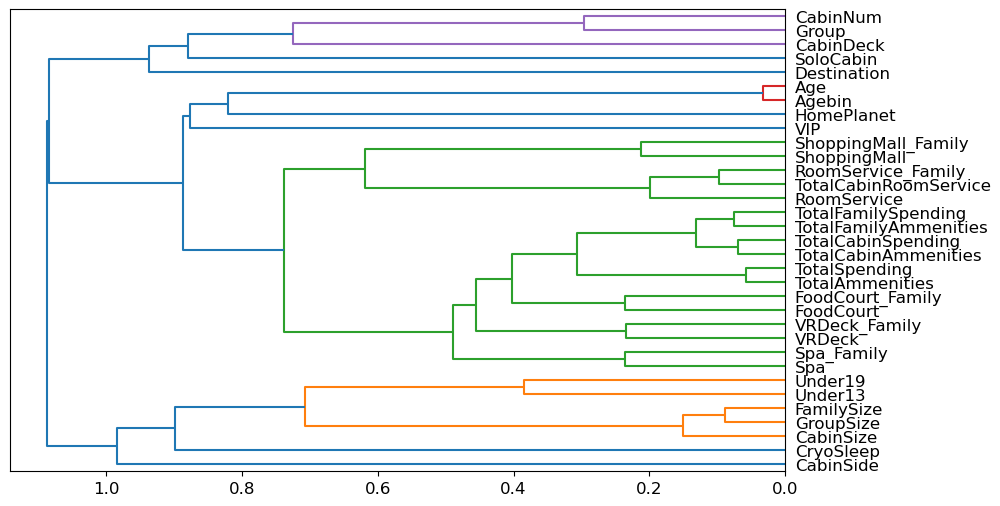

In [ ]:
cluster_columns(xs)


In [ ]:
((m.predict(valid_xs) > 0.5) == valid_y).sum() / len(valid_y)

0.7828646173969915

In [ ]:
m = RandomForestClassifier(n_estimators= 100, max_leaf_nodes= 50)
m.fit(xs, y)
preds = m.predict(valid_xs)
print(mean_absolute_error(valid_y, preds))
print()
(preds == valid_y).sum() /len(valid_y)

0.197514715500327



0.8024852844996729

In [ ]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = rf_feat_importance(m, xs)
print(fi)

                     cols       imp
20          TotalSpending  0.123041
1               CryoSleep  0.103466
18        TotalAmmenities  0.092965
14                    Spa  0.072663
15                 VRDeck  0.071012
12              FoodCourt  0.047459
11            RoomService  0.042532
13           ShoppingMall  0.037480
4               CabinDeck  0.036482
26       FoodCourt_Family  0.034733
28  TotalFamilyAmmenities  0.032545
21     TotalCabinSpending  0.032507
29    TotalFamilySpending  0.031153
0              HomePlanet  0.031082
23          VRDeck_Family  0.025301
19   TotalCabinAmmenities  0.025021
24             Spa_Family  0.023930
25     RoomService_Family  0.021064
22  TotalCabinRoomService  0.020214
27    ShoppingMall_Family  0.014461
17               CabinNum  0.014176
16                  Group  0.013224
10                    Age  0.012508
32              CabinSize  0.009586
6               SoloCabin  0.008019
5               CabinSide  0.007132
30              GroupSize  0

In [ ]:
to_new = to.train.new(test1)
to_new.process()
testtran = [True if x == 1 else False for x in list(m.predict(to_new.xs))]
test1['Transported'] = testtran
droptest['Transported'] = 'False'
ret = pd.concat([test1,droptest])
ret = ret[['PassengerId','Transported']]
ret.to_csv('submit.csv',index=False)

In [ ]:
splits = RandomSplitter(seed = 1)(range_of(train1))
dep_var = 'Transported'
procs = [Categorify,FillMissing]
cont,cat = cont_cat_split(train1, 1, dep_var=dep_var)
to = TabularPandas(train1, procs, cat, cont, y_names=dep_var,splits = splits)

xs,y = to.train.xs,to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

dls = to.dataloaders(512)
learn = tabular_learner(dls)

In [ ]:
learn.lr_find()


In [ ]:
learn.fit_one_cycle(5, 0.01)


epoch,train_loss,valid_loss,time
0,0.465627,0.456810,00:01
1,0.453391,0.462754,00:01
2,0.439894,0.432700,00:01
3,0.429819,0.414850,00:01
4,0.421796,0.410634,00:01


In [ ]:
preds,targs = learn.get_preds()
r_mse(preds,targs)


0.605889